In [1]:
library("foreign")
library("gdata")
library("lme4")
library("lmerTest")
library("psych")
library("MuMIn")
library("effsize")
library("corrplot")

Warning message:
: package ‘gdata’ was built under R version 3.2.4gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

Następujący obiekt został zakryty z ‘package:stats’:

    nobs

Następujący obiekt został zakryty z ‘package:utils’:

    object.size

Loading required package: Matrix
Warning message:
: package ‘lmerTest’ was built under R version 3.2.4
Attaching package: ‘lmerTest’

Następujący obiekt został zakryty z ‘package:lme4’:

    lmer

Następujący obiekt został zakryty z ‘package:stats’:

    step

Warning message:
: package ‘psych’ was built under R version 3.2.4Warning message:
: package ‘MuMIn’ was built under R version 3.2.4Warning message:
: package ‘effsize’ was built under R version 3.2.4Warning message:
: package ‘corrplot’ was built under R version 3.2.4

# Get results table to store game progress

In [2]:
# Load IDs
demo <- read.xls("/Users/marcel/projects/treningi_Justyna/dane_wszystkie.xlsx",2)
demo$kid <- as.character(levels(demo$kid)[demo$kid])
demo$group <- as.character(levels(demo$group)[demo$group])

In [3]:
results <- data.frame(unique(demo[demo$include == 1 & demo$group == 'EXP',2]))
results$apples = NA
results$fish = NA
results$ee = NA
results$jigsaw = NA
names(results) = c('id','apples','fish','ee','jigsaw')

# Apples

## Prepare the data

In [4]:
# Load data
data_apples <- read.xls("/Users/marcel/projects/treningi_Justyna/07.01.2014/jablka/jablka.xlsx")
names(data_apples) <- c("kid","id","session","type")
data_apples$kid <- as.character(levels(data_apples$kid)[data_apples$kid])
data_apples$type <- as.character(levels(data_apples$type)[data_apples$type])

### Remove data from excluded kids

In [5]:
excluded <- demo$kid[demo$include == 0]
excluded_rows = c()

for (n in 1:length(excluded)) {
    excluded_rows = c(excluded_rows, which(data_apples$kid == excluded[n]))
}

data_apples <- data_apples[-excluded_rows,]
included = unique(data_apples$kid)

N = length(included)
N

[1] 27

### Assign correct IDs

In [6]:
for (k in included) {
    ID = demo$ID[demo$kid == k]
    if (ID > 0) {
        data_apples$id[data_apples$kid == k] = ID
    } else {
        data_apples$id[data_apples$kid == k] = NA
    }
}

# Check if all IDs have been assigned correctly
sum(is.na(data_apples$id))

[1] 0

In [7]:
included_id = unique(data_apples$id)

### Additional cleanups

In [8]:
trim <- function (x) gsub("^\\s+|\\s+$", "", x)

data_apples$type <- trim(data_apples$type)

bads1 <- grep('[0-9]',data_apples$type)
data_apples <- data_apples[-bads1,]
bads2 <- which(data_apples$type == 'w  lewo')
data_apples <- data_apples[-bads2,]
sum(length(bads1),length(bads2))

[1] 347

## Prepare result table

In [9]:
# Create empty vectors for IDs and session IDs
ids <- rep(sort(included_id),each = 10)
sess <- rep(1:10,N)

In [10]:
results_apples <- data.frame(ids,sess)
results_apples$nstim = 0
results_apples$hits = 0
results_apples$falstarts = 0
results_apples$misses = 0
results_apples$fa = 0
results_apples$cr = 0
results_apples$nr = 0

### Fill the results table

In [11]:
for (i in 1:N) {
  id = included_id[i] 
  for (j in 1:10) {
    r = i*10-(10-j)
    results_apples$nstim[r] = sum(data_apples$id == id & data_apples$session == j)
    results_apples$hits[r] = sum(data_apples$id == id & data_apples$session == j & data_apples$type == 'hit')
    results_apples$falstarts[r] = sum(data_apples$id == id & data_apples$session == j & data_apples$type == 'falstart')
    results_apples$misses[r] = sum(data_apples$id == id & data_apples$session == j & data_apples$type == 'miss')
    results_apples$fa[r] = sum(data_apples$id == id & data_apples$session == j & data_apples$type == 'fa')
    results_apples$cr[r] = sum(data_apples$id == id & data_apples$session == j & data_apples$type == 'cr')
    results_apples$nr[r] = sum(data_apples$id == id & data_apples$session == j & data_apples$type == 'zmylka')
  }
}

In [12]:
results_apples$errors <- results_apples$falstarts + results_apples$fa + results_apples$misses + results_apples$nr
results_apples$correct <- results_apples$cr + results_apples$hits + results_apples$nr
results_apples$sum <- results_apples$falstarts + results_apples$misses + results_apples$fa + results_apples$nr + results_apples$cr + results_apples$hits

results_apples$hitrate <- results_apples$correct/(results_apples$nstim)
results_apples$errrate <- results_apples$errors/(results_apples$nstim)

In [13]:
results_apples <- results_apples[!is.na(results_apples$errrate),]

In [14]:
results_apples

,ids,sess,nstim,hits,falstarts,misses,fa,cr,nr,errors,correct,sum,hitrate,errrate
1,1,1,65,42,7,1,6,7,2,16,51,65,0.784615384615385,0.246153846153846
2,1,2,63,46,2,0,6,8,1,9,55,63,0.873015873015873,0.142857142857143
3,1,3,65,52,0,0,8,4,1,9,57,65,0.876923076923077,0.138461538461538
4,1,4,65,48,0,0,6,10,1,7,59,65,0.907692307692308,0.107692307692308
5,1,5,65,46,2,2,3,12,0,7,58,65,0.892307692307692,0.107692307692308
6,1,6,130,118,1,0,3,7,1,5,126,130,0.969230769230769,0.0384615384615385
7,1,7,130,117,1,0,4,4,4,9,125,130,0.961538461538462,0.0692307692307692
8,1,8,128,106,3,0,6,10,3,12,119,128,0.9296875,0.09375
9,1,9,130,110,3,0,6,11,0,9,121,130,0.930769230769231,0.0692307692307692
10,1,10,130,113,2,0,1,14,0,3,127,130,0.976923076923077,0.0230769230769231


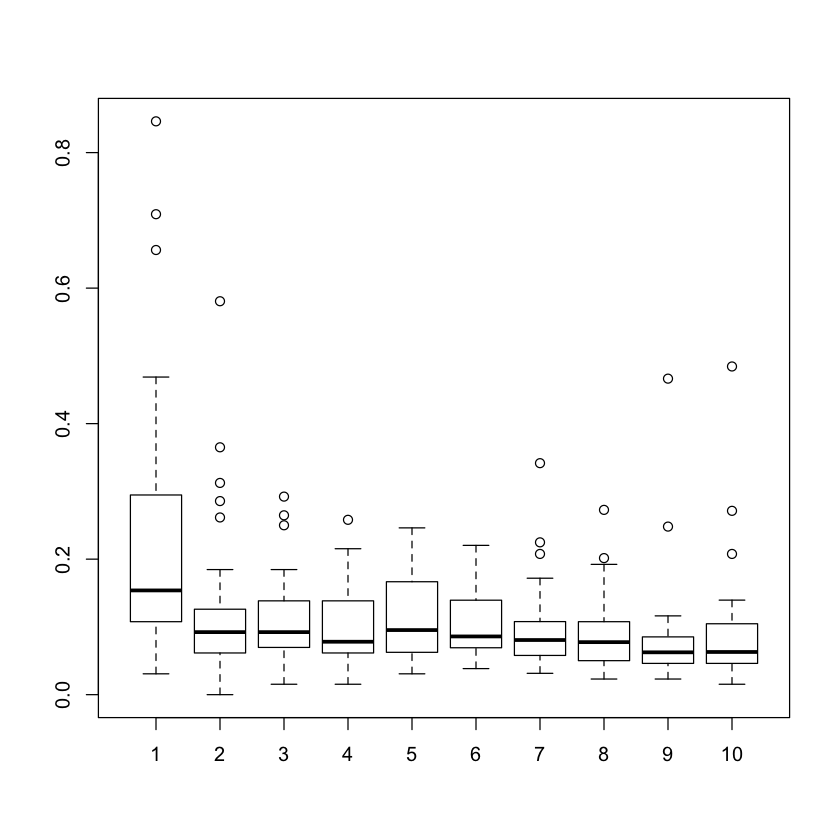

In [15]:
boxplot(errrate ~ sess, results_apples)

## Descriptive statistics

In [16]:
describeBy(results_apples,c("sess"))

group: 1
          vars  n  mean    sd median trimmed   mad   min   max range  skew
ids          1 27 15.00  8.97  15.00   14.91 11.86  1.00 30.00 29.00  0.09
sess         2 27  1.00  0.00   1.00    1.00  0.00  1.00  1.00  0.00   NaN
nstim        3 27 64.19  2.09  65.00   64.70  0.00 55.00 65.00 10.00 -3.38
hits         4 27 41.19 13.02  45.00   42.74  8.90  3.00 57.00 54.00 -1.29
falstarts    5 27  5.11  7.66   2.00    3.65  2.97  0.00 28.00 28.00  1.78
misses       6 27  5.74 10.65   2.00    3.65  1.48  0.00 54.00 54.00  3.49
fa           7 27  2.85  2.25   2.00    2.70  1.48  0.00  8.00  8.00  0.73
cr           8 27  7.52  3.45   7.00    7.52  4.45  1.00 13.00 12.00 -0.07
nr           9 27  1.78  1.65   1.00    1.61  1.48  0.00  7.00  7.00  1.19
errors      10 27 15.48 13.16  10.00   13.70  7.41  2.00 55.00 53.00  1.41
correct     11 27 50.48 13.70  56.00   52.52  7.41 11.00 63.00 52.00 -1.50
sum         12 27 64.19  2.09  65.00   64.70  0.00 55.00 65.00 10.00 -3.38
hitrate     13 2

## Did the subjects improve?

In [17]:
r_apples = t.test(results_apples$errrate[results_apples$sess == 1], 
       results_apples$errrate[results_apples$sess == 10],
       alternative = "greater",
       paired = T, var.equal = F)
r_apples


	Paired t-test

data:  results_apples$errrate[results_apples$sess == 1] and results_apples$errrate[results_apples$sess == 10]
t = 3.1481, df = 26, p-value = 0.002048
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.06814796        Inf
sample estimates:
mean of the differences 
              0.1487268 


In [18]:
cohen.d(results_apples$errrate[results_apples$sess == 1], 
       results_apples$errrate[results_apples$sess == 10],
       pooled = T, paired = T, na.rm = T)


Cohen's d

d estimate: 0.6058542 (medium)
95 percent confidence interval:
       inf        sup 
0.03620591 1.17550242 

## Modeling of progress

We have chosen a linear model to approximate the progress in task performance. There is simply not enough data to fit more complex models, which would also lead to much more complicated interpretations of the parameters. Here we interpret the intercept as the initial error rate for training session 1 and the slope as average per-session improvement.

In [19]:
m_apples = lmer(errrate ~ (sess|ids) + sess, results_apples)
summary(m_apples)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: errrate ~ (sess | ids) + sess
   Data: results_apples

REML criterion at convergence: -524.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1426 -0.3952 -0.1428  0.3598  5.2718 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr 
 ids      (Intercept) 0.0188464 0.13728       
          sess        0.0004117 0.02029  -0.96
 Residual             0.0056949 0.07546       
Number of obs: 269, groups:  ids, 27

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  0.176665   0.028224 26.009000   6.259 1.26e-06 ***
sess        -0.010668   0.004219 26.001000  -2.528   0.0179 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
     (Intr)
sess -0.949

We see the average effect of training (not so strong), but the most interesting things happen at the random effects level. There is strong negative correlation between intercept and session slope, that is between initial level of performance in the game and average per-session improvement. The correlation is so strong that one could conclude that the initial level of game performance determines the overall improvement.

### Model assessment

#### Explained variance

In [20]:
r.squaredGLMM(m_apples)

R2m        R2c 
0.07917863 0.52327445

<b>R2m</b> refers to variance explained by fixed effects, <b>R2c</b> to total variance explained by the model. We can see that majority of variance in the data can be attributed to individual differences between subjects. 

#### Residuals

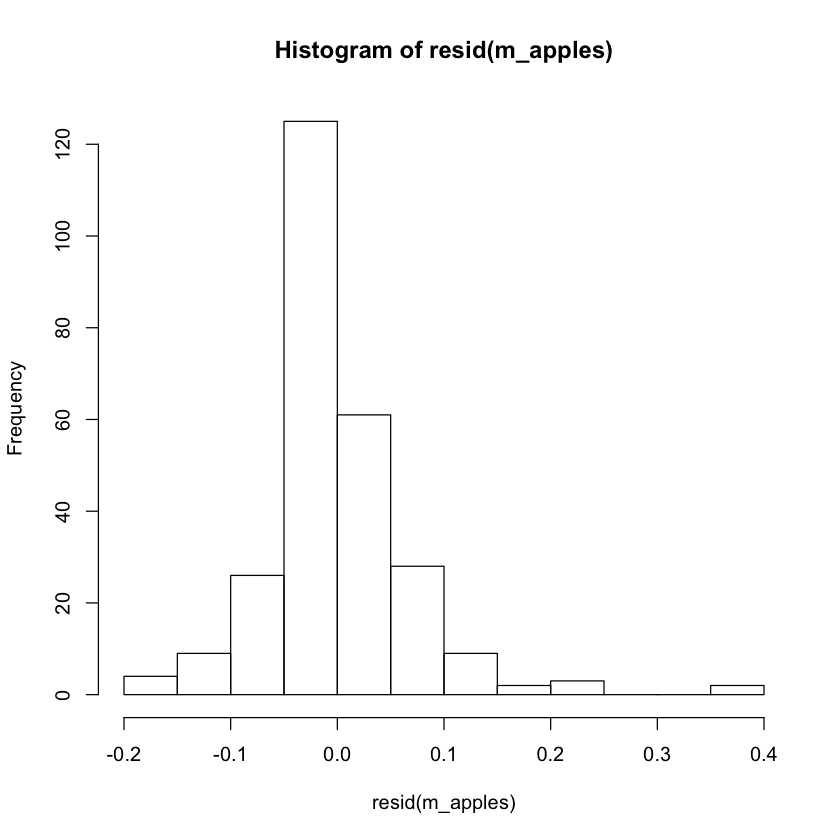

In [21]:
hist(resid(m_apples))

Residuals look reasonable, there are however few outliers on the right side of the residual distribution.

### Get individual estimates

In [22]:
apples_random = ranef(m_apples)
apples_fixed = fixef(m_apples)

In [23]:
apples_random$ids

,(Intercept),sess
1,0.02146778,-0.005514064
2,-0.05725867,0.002647164
3,-0.08788584,0.02016442
4,0.07027294,-0.01085752
5,0.01989836,-0.004849753
6,-0.05876975,0.003888169
7,-0.06561046,0.009000672
8,-0.05080012,0.004260134
9,-0.09209738,0.01176674
10,-0.04731412,0.002568626


In [24]:
start_apples <- apples_random$ids$'(Intercept)' + apples_fixed[1]
prog_apples <- (apples_random$ids$sess + apples_fixed[2])*10

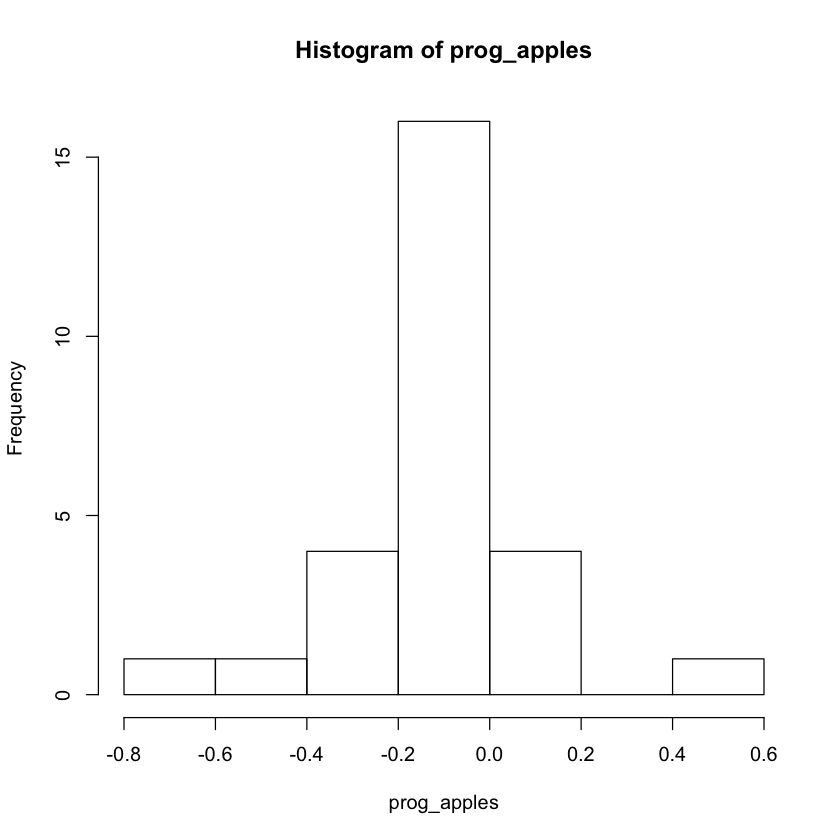

In [25]:
hist(prog_apples)

In [26]:
included_id[which(prog_apples > 0.2)]

[1] 4

We can see some progress in game performance over 10 training sessions for vast majority ofthe subjects (23/27). Four subjects worsened their performance, with one outlier subject who got significantly worse compared to the pre-test. The outlier is subject 4.

In [27]:
results$apples <- prog_apples

# Jigsaw

In [28]:
data_jigsaw = read.xls("/Users/marcel/projects/treningi_Justyna/07.01.2014/ukladanki/ukladanki_eksperymentalna.xlsx")
names(data_jigsaw) = c('kid','id','sess','ver','points','switches','level')

## Remove data

In [29]:
for (n in 1:length(excluded)) {
    excluded_rows = c(excluded_rows, which(data_jigsaw$kid == excluded[n]))
}

data_jigsaw <- data_jigsaw[-excluded_rows,]
included = unique(data_jigsaw$kid)
N = length(included)
N

[1] 27

## Recode IDs

In [30]:
for (k in included) {
    ID = demo$ID[demo$kid == k]
    if (ID > 0) {
        data_jigsaw$id[data_jigsaw$kid == k] = ID
    } else {
        data_jigsaw$id[data_jigsaw$kid == k] = NA
    }
}

# Check if all IDs have been assigned correctly
sum(is.na(data_jigsaw$id))

[1] 0

### Sort data according to IDs

In [31]:
data_jigsaw <- data_jigsaw[order(data_jigsaw$id),]

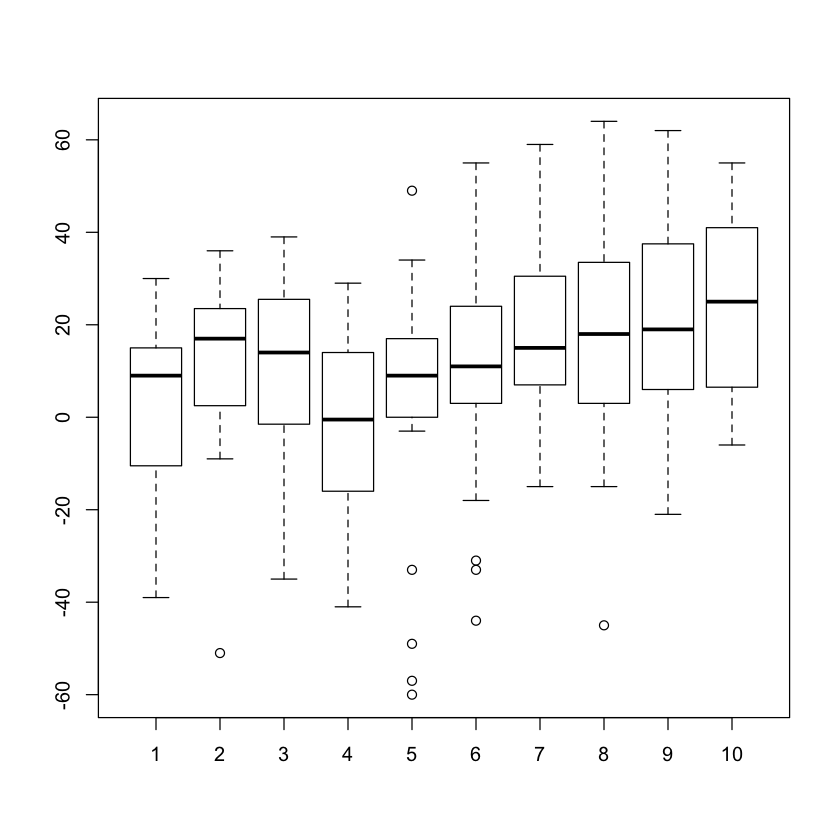

In [32]:
boxplot(points ~ sess, data_jigsaw)

## Descriptives

In [33]:
describeBy(data_jigsaw,c("sess"))

group: 1
         vars  n  mean    sd median trimmed   mad min max range  skew kurtosis
kid*        1 27 14.78  8.44     15   14.74 10.38   1  30    29 -0.01    -1.27
id          2 27 15.00  8.97     15   14.91 11.86   1  30    29  0.09    -1.34
sess        3 27  1.00  0.00      1    1.00  0.00   1   1     0   NaN      NaN
ver         4 27  1.04  0.19      1    1.00  0.00   1   2     1  4.63    20.22
points      5 27  1.67 21.43      9    2.78 14.83 -39  30    69 -0.66    -0.91
switches    6 27  0.11  0.32      0    0.04  0.00   0   1     1  2.34     3.61
level       7 27  1.00  0.00      1    1.00  0.00   1   1     0   NaN      NaN
           se
kid*     1.62
id       1.73
sess     0.00
ver      0.04
points   4.12
switches 0.06
level    0.00
------------------------------------------------------------ 
group: 2
         vars  n  mean    sd median trimmed   mad min max range  skew kurtosis
kid*        1 27 14.78  8.44     15   14.74 10.38   1  30    29 -0.01    -1.27
id          2 27 1

## Did the subjects improve?

In [34]:
r_jigsaw = t.test(data_jigsaw$points[data_jigsaw$sess == 1], 
       data_jigsaw$points[data_jigsaw$sess == 10],
       alternative = "less",
       paired = T, var.equal = F)
r_jigsaw


	Paired t-test

data:  data_jigsaw$points[data_jigsaw$sess == 1] and data_jigsaw$points[data_jigsaw$sess == 10]
t = -4.6631, df = 26, p-value = 4.089e-05
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf -14.70483
sample estimates:
mean of the differences 
              -23.18519 


In [35]:
cohen.d(data_jigsaw$points[data_jigsaw$sess == 1], 
       data_jigsaw$points[data_jigsaw$sess == 10],
       pooled = T, paired = T, na.rm = T)


Cohen's d

d estimate: -0.8974216 (large)
95 percent confidence interval:
       inf        sup 
-1.4823336 -0.3125096 

## Model progress in Jigsaw

In [36]:
m_jigsaw = lmer(points ~ (sess|id) + sess, data_jigsaw)
summary(m_jigsaw)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: points ~ (sess | id) + sess
   Data: data_jigsaw

REML criterion at convergence: 2300.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4905 -0.5079 -0.0295  0.5762  2.4950 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 id       (Intercept) 300.078  17.323        
          sess          3.929   1.982   -0.52
 Residual             232.067  15.234        
Number of obs: 268, groups:  id, 27

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)  -1.5471     3.8917 25.9420  -0.398    0.694    
sess          2.4479     0.4998 26.0210   4.898 4.39e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
     (Intr)
sess -0.637

We see a less significant correlation between initial and final performance, which is good.

### Model assessment

#### Explained variance

In [37]:
r.squaredGLMM(m_jigsaw)

R2m      R2c 
0.093079 0.567431

Once again the majority of variance can be explained with random effects of the model. Fixed and random effects explain 56.7% of total variance.

#### Residuals

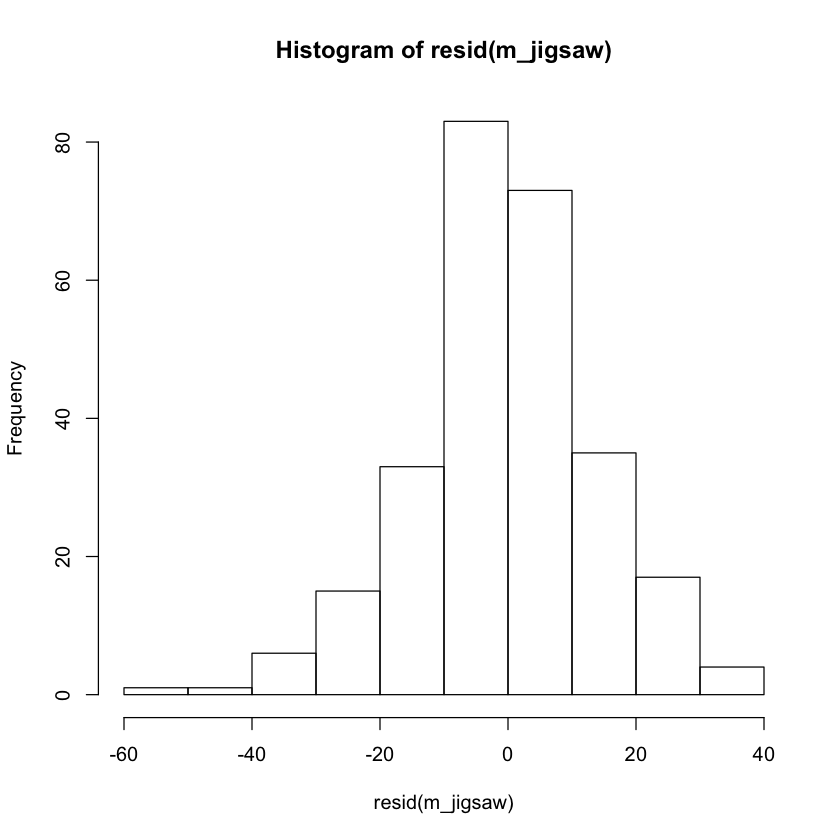

In [38]:
hist(resid(m_jigsaw))

The distribution is left-skewed, with 2 subjects with residuals < -40

### Individual progress

In [39]:
jigsaw_random = ranef(m_jigsaw)
jigsaw_fixed = fixef(m_jigsaw)

In [40]:
jigsaw_random$id

,(Intercept),sess
1,-0.5168983,0.8614277
2,16.10068,0.8474336
3,10.29287,1.753916
4,-1.242455,-1.694616
5,19.4755,-1.113128
6,-13.56183,0.4489459
7,4.621305,-2.093458
8,22.44248,-3.098555
9,2.35208,-0.5043566
10,1.518459,-1.386225


In [41]:
start_jigsaw <- jigsaw_random$id$'(Intercept)' + jigsaw_fixed[1]
prog_jigsaw <- (jigsaw_random$id$sess + jigsaw_fixed[2])*10

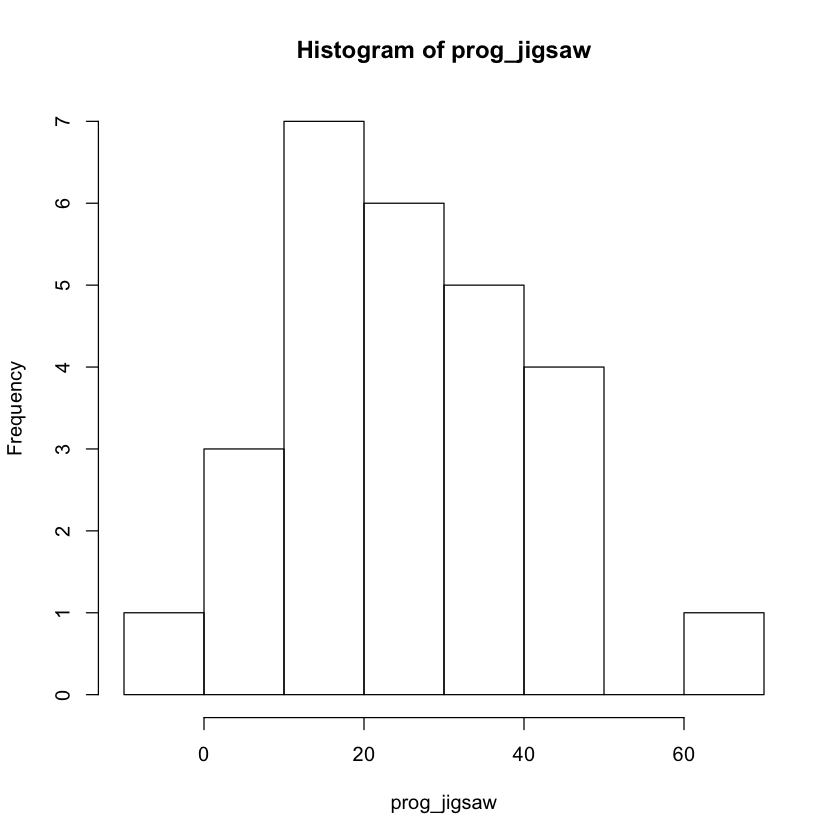

In [42]:
hist(prog_jigsaw)

Only one subject did not improve his/her score at all, with majority of the subjects increasing the number of points by ~20 points

In [43]:
results$jigsaw <- prog_jigsaw

# Fish

## Data preprocessing

Here part of the data was logged in a different way than the other. We need to load them both and bring them to the same format.

In [44]:
data_fish2 <- read.xls("/Users/marcel/projects/treningi_Justyna/07.01.2014/rybki/rybki1.xlsx")
data_fish2 <- data_fish2[,c(1,2,3,4)]

data_fish3 <- read.xls("/Users/marcel/projects/treningi_Justyna/07.01.2014/rybki/rybki2.xlsx",header=F)
data_fish3$V5 <- as.character(levels(data_fish3$V5)[data_fish3$V5])
data_fish3$V5[data_fish3$V5 == 'DOBRA'] = 1
data_fish3$V5[data_fish3$V5 == 'ZLA'] = 0
data_fish3$V5[data_fish3$V5 == 'ZMIANA'] = 3
data_fish3$V5 <- as.numeric(data_fish3$V5)
data_fish3 <- data_fish3[,c(1,2,3,5)]

names(data_fish2) <- c('kid','id','sess','resp')
names(data_fish3) <- c('kid','id','sess','resp')

data_fish <- rbind(data_fish2, data_fish3)
data_fish$kid <- as.character(levels(data_fish$kid)[data_fish$kid])

### Remove some subjects

In [45]:
for (n in 1:length(excluded)) {
    excluded_rows = c(excluded_rows, which(data_fish$kid == excluded[n]))
}

data_fish <- data_fish[-excluded_rows,]
included = unique(data_fish$kid)

N = length(included)
N

[1] 27

### Recode IDs

In [46]:
for (k in included) {
    ID = demo$ID[demo$kid == k]
    if (ID > 0) {
        data_fish$id[data_fish$kid == k] = ID
    } else {
        data_fish$id[data_fish$kid == k] = NA
    }
}

# Check if all IDs have been assigned correctly
sum(is.na(data_fish$id))

[1] 0

In [47]:
included_id = unique(data_fish$id)

### Figure out if each fish was a target

In [48]:
data_fish$target = NA

for (i in unique(data_fish$id)) {
  for (j in 1:10) {
    rybka = 0
    for (k in which(data_fish$id == i & data_fish$sess == j)) {
      if (data_fish$resp[k] == 3) {
        rybka = rybka + 1
      }
      data_fish$target[k] = rybka%%3      
    }
  }
}

In [49]:
ids <- rep(sort(included_id), each = 10)
sess <- rep(1:10,N)

In [50]:
results_fish <- data.frame(ids,sess)
results_fish$nstim = NA
results_fish$shifts = NA
results_fish$hits = NA
results_fish$errors = NA

In [51]:
for (i in 1:N) {
  id = included_id[i] 
  for (j in 1:10) {
    r = i*10-(10-j)
    results_fish$shifts[r] = sum(data_fish$id == id & data_fish$sess == j & data_fish$resp == 3)
    results_fish$nstim[r] = sum(data_fish$id == id & data_fish$sess == j) - results_fish$shifts[r]
    results_fish$hits[r] = sum(data_fish$id == id & data_fish$sess == j & data_fish$resp == 1)
    results_fish$errors[r] = sum(data_fish$id == id & data_fish$sess == j & data_fish$resp == 0)      
  }
}

results_fish$errrate = results_fish$errors/results_fish$nstim

In [52]:
results_fish[is.na(results_fish$errrate),]

,ids,sess,nstim,shifts,hits,errors,errrate
12,2,2,0,0,0,0,NaN
55,6,5,0,0,0,0,NaN
56,6,6,0,0,0,0,NaN
57,6,7,0,0,0,0,NaN
58,6,8,0,0,0,0,NaN
59,6,9,0,0,0,0,NaN
85,9,5,0,0,0,0,NaN
171,19,1,0,0,0,0,NaN
172,19,2,0,0,0,0,NaN
173,19,3,0,0,0,0,NaN


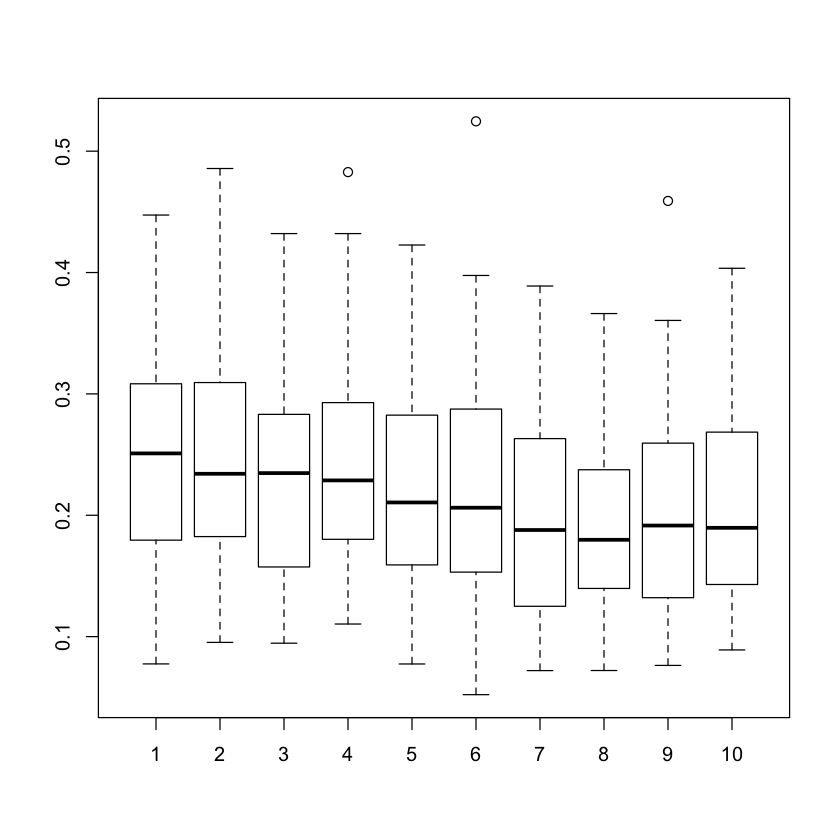

In [53]:
boxplot(errrate ~ sess, results_fish)

## Descriptive statistics

In [54]:
describeBy(results_fish,c("sess"))

group: 1
        vars  n   mean    sd median trimmed   mad  min    max  range  skew
ids        1 27  15.00  8.97  15.00   14.91 11.86 1.00  30.00  29.00  0.09
sess       2 27   1.00  0.00   1.00    1.00  0.00 1.00   1.00   0.00   NaN
nstim      3 27 112.74 42.53 117.00  114.09 37.06 0.00 212.00 212.00 -0.35
shifts     4 27   1.44  0.89   1.00    1.43  1.48 0.00   3.00   3.00  0.00
hits       5 27  85.19 33.56  92.00   86.96 29.65 0.00 146.00 146.00 -0.59
errors     6 27  27.56 14.29  27.00   26.57 10.38 0.00  66.00  66.00  0.74
errrate    7 26   0.25  0.09   0.25    0.25  0.10 0.08   0.45   0.37  0.34
        kurtosis   se
ids        -1.34 1.73
sess         NaN 0.00
nstim       0.53 8.19
shifts     -0.87 0.17
hits       -0.14 6.46
errors      0.61 2.75
errrate    -0.53 0.02
------------------------------------------------------------ 
group: 2
        vars  n   mean    sd median trimmed   mad min    max  range  skew
ids        1 27  15.00  8.97  15.00   14.91 11.86 1.0  30.00  29.00  0

## Did the subjects improve?

In [55]:
r_fish = t.test(results_fish$errrate[results_fish$sess == 1], 
       results_fish$errrate[results_fish$sess == 10],
       alternative = "greater",
       paired = T, var.equal = F)
r_fish


	Paired t-test

data:  results_fish$errrate[results_fish$sess == 1] and results_fish$errrate[results_fish$sess == 10]
t = 3.0809, df = 25, p-value = 0.002484
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.01924541        Inf
sample estimates:
mean of the differences 
             0.04319316 


In [56]:
cohen.d(results_fish$errrate[results_fish$sess == 1], 
       results_fish$errrate[results_fish$sess == 10],
       pooled = T, paired = T, na.rm = T)


Cohen's d

d estimate: 0.6042091 (medium)
95 percent confidence interval:
       inf        sup 
0.02277816 1.18563996 

## Modeling Fish progress

In [57]:
m_fish = lmer(errrate ~ (sess|ids) + sess, results_fish)
summary(m_fish)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: errrate ~ (sess | ids) + sess
   Data: results_fish

REML criterion at convergence: -751.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8436 -0.5415 -0.0279  0.6282  2.8165 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr 
 ids      (Intercept) 0.0079090 0.088932      
          sess        0.0000209 0.004572 -0.58
 Residual             0.0019785 0.044480      
Number of obs: 258, groups:  ids, 27

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  0.260782   0.018200 26.232000  14.328 6.44e-14 ***
sess        -0.006564   0.001317 24.503000  -4.983 4.11e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
     (Intr)
sess -0.587

### Model assessment

#### Explained variance

In [58]:
r.squaredGLMM(m_fish)

R2m        R2c 
0.04260709 0.76635265

#### Residuals

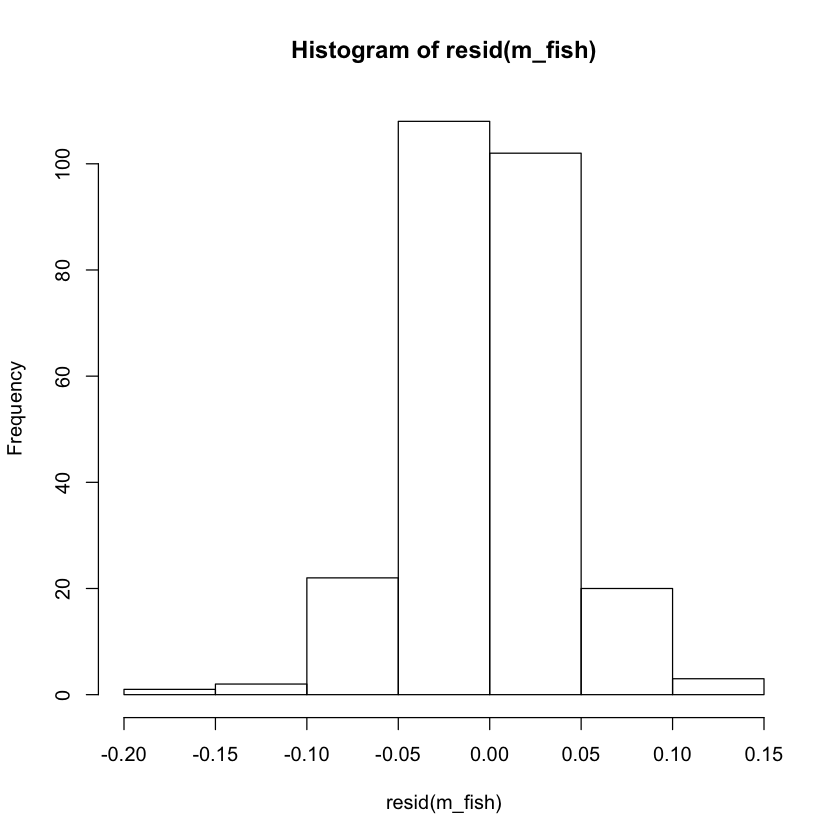

In [59]:
hist(resid(m_fish))

## Individual progress

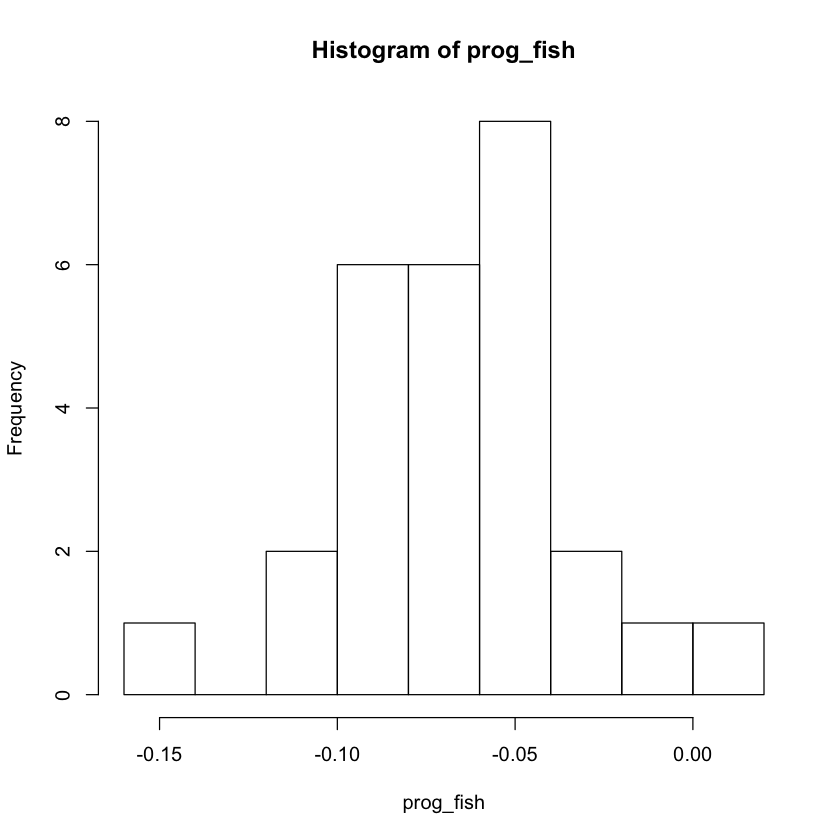

In [60]:
fish_random = ranef(m_fish)
fish_fixed = fixef(m_fish)

start_fish <- fish_random$ids$'(Intercept)' + fish_fixed[1]
prog_fish <- (fish_random$id$sess + fish_fixed[2])*10

hist(prog_fish)

In [61]:
results$fish <- prog_fish

# Easter eggs

## Prepare the data

In [62]:
data_ee = read.xls('/Users/marcel/projects/treningi_Justyna/07.01.2014/pisanki/pisanki _eksperymentalna.xlsx')
data_ee$nstim <- data_ee$pis_dobre+data_ee$pisOM+data_ee$pisFA
data_ee$errrate <- data_ee$pis_bledy/data_ee$nstim
names(data_ee) = c('kid','id','sess','correct','miss','fa','errors','nstim','errrate')

### Remove IDs

In [63]:
for (n in 1:length(excluded)) {
    excluded_rows = c(excluded_rows, which(data_ee$kid == excluded[n]))
}

data_ee <- data_ee[-excluded_rows,]
included = unique(data_ee$kid)
N = length(included)
N

[1] 27

### Recode IDs

In [64]:
for (k in included) {
    ID = demo$ID[demo$kid == k]
    if (ID > 0) {
        data_ee$id[data_ee$kid == k] = ID
    } else {
        data_ee$id[data_ee$kid == k] = NA
    }
}

# Check if all IDs have been assigned correctly
sum(is.na(data_ee$id))

[1] 0

### Reorder data

In [65]:
data_ee <- data_ee[order(data_ee$id),]

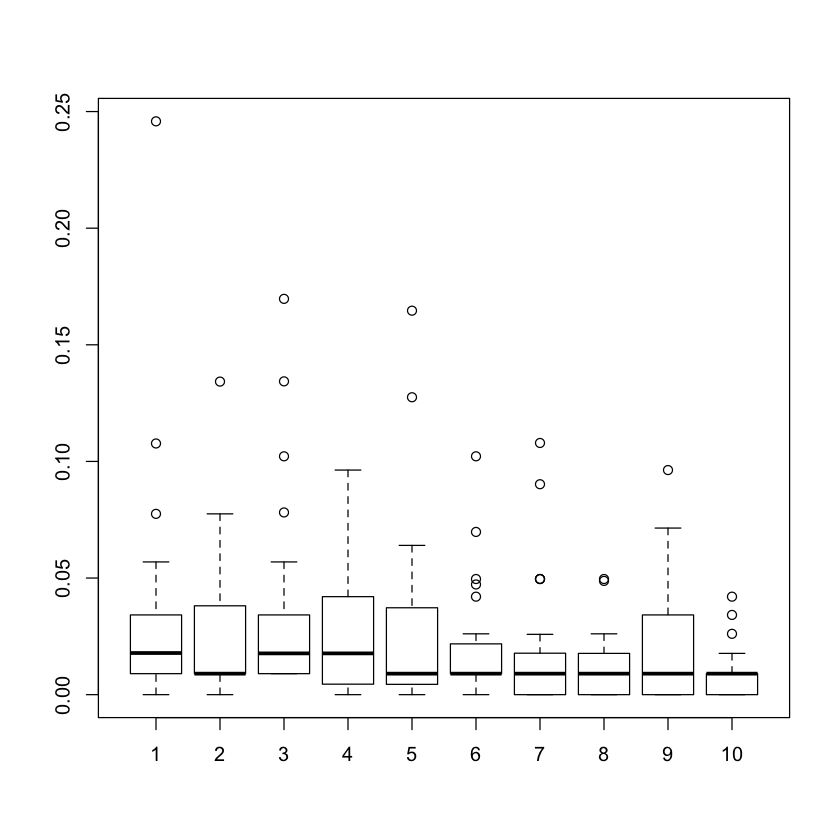

In [66]:
boxplot(errrate ~ sess, data_ee)

## Descriptives

In [67]:
describeBy(data_ee,c("sess"))

group: 1
        vars  n   mean    sd median trimmed   mad min    max range  skew
kid*       1 27  14.78  8.44  15.00   14.74 10.38   1  30.00 29.00 -0.01
id         2 27  15.00  8.97  15.00   14.91 11.86   1  30.00 29.00  0.09
sess       3 27   1.00  0.00   1.00    1.00  0.00   1   1.00  0.00   NaN
correct    4 27 112.52  5.08 111.00  111.57  1.48 109 135.00 26.00  3.24
miss       5 27   1.63  2.51   1.00    1.17  1.48   0  10.00 10.00  1.89
fa         6 27   3.00  7.34   1.00    1.30  1.48   0  37.00 37.00  3.78
errors     7 27   4.59  8.45   2.00    2.87  1.48   0  44.00 44.00  3.78
nstim      8 27 117.15 13.44 113.00  114.61  2.97 109 179.00 70.00  3.62
errrate    9 27   0.03  0.05   0.02    0.02  0.01   0   0.25  0.25  3.19
        kurtosis   se
kid*       -1.27 1.62
id         -1.34 1.73
sess         NaN 0.00
correct    11.37 0.98
miss        2.86 0.48
fa         14.27 1.41
errors     14.60 1.63
nstim      13.69 2.59
errrate    10.79 0.01
-----------------------------------------

The last two session for subject 22 are missing from the data.

## Did the subjects improve on average?

In this analysis we remove the subject with missing data.

In [68]:
r_ee = t.test(data_ee$errrate[data_ee$sess == 1 & data_ee$id != 22], 
       data_ee$errrate[data_ee$sess == 10],
       alternative = "greater",
       paired = T, var.equal = F)
r_ee


	Paired t-test

data:  data_ee$errrate[data_ee$sess == 1 & data_ee$id != 22] and data_ee$errrate[data_ee$sess == 10]
t = 2.7365, df = 25, p-value = 0.005631
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.008257148         Inf
sample estimates:
mean of the differences 
             0.02197199 


In [69]:
cohen.d(data_ee$errrate[data_ee$sess == 1 & data_ee$id != 22], 
       data_ee$errrate[data_ee$sess == 10],
       pooled = T, paired = T, na.rm = T)


Cohen's d

d estimate: 0.5366803 (medium)
95 percent confidence interval:
        inf         sup 
-0.04196421  1.11532472 

### Could the missing subjects affect the results?

We can also check the data for all subjects by comparing sessions 1 and 8.

In [70]:
r_ee_s8 = t.test(data_ee$errrate[data_ee$sess == 1], 
       data_ee$errrate[data_ee$sess == 8],
       alternative = "greater",
       paired = T, var.equal = F)
r_ee_s8


	Paired t-test

data:  data_ee$errrate[data_ee$sess == 1] and data_ee$errrate[data_ee$sess == 8]
t = 2.4675, df = 26, p-value = 0.01025
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.007215685         Inf
sample estimates:
mean of the differences 
             0.02336854 


In [71]:
cohen.d(data_ee$errrate[data_ee$sess == 1], 
       data_ee$errrate[data_ee$sess == 8],
       pooled = T, paired = T, na.rm = T)


Cohen's d

d estimate: 0.4748781 (small)
95 percent confidence interval:
        inf         sup 
-0.08975263  1.03950885 

We can conclude that in both cases a significant increase in performance is observed and the person with missing data did not affect the results. We will be able to calculate the progress for that person based on 8 sessions which are available, due to the usage of a hierarchical model.

## Model progress in Easter Eggs game

In [72]:
m_ee = lmer(errrate ~ (sess|id) + sess, data_ee)
summary(m_ee)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: errrate ~ (sess | id) + sess
   Data: data_ee

REML criterion at convergence: -1162.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2626 -0.4133 -0.2196  0.0971  5.3573 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr 
 id       (Intercept) 1.248e-03 0.035329      
          sess        1.281e-05 0.003579 -0.97
 Residual             5.588e-04 0.023638      
Number of obs: 268, groups:  id, 27

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  0.0362836  0.0074793 25.8930000   4.851 5.03e-05 ***
sess        -0.0025134  0.0008543 24.6430000  -2.942    0.007 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
     (Intr)
sess -0.927

### Model assessment

#### Variance explained

In [73]:
r.squaredGLMM(m_ee)

R2m        R2c 
0.05143783 0.44652121

#### Residuals

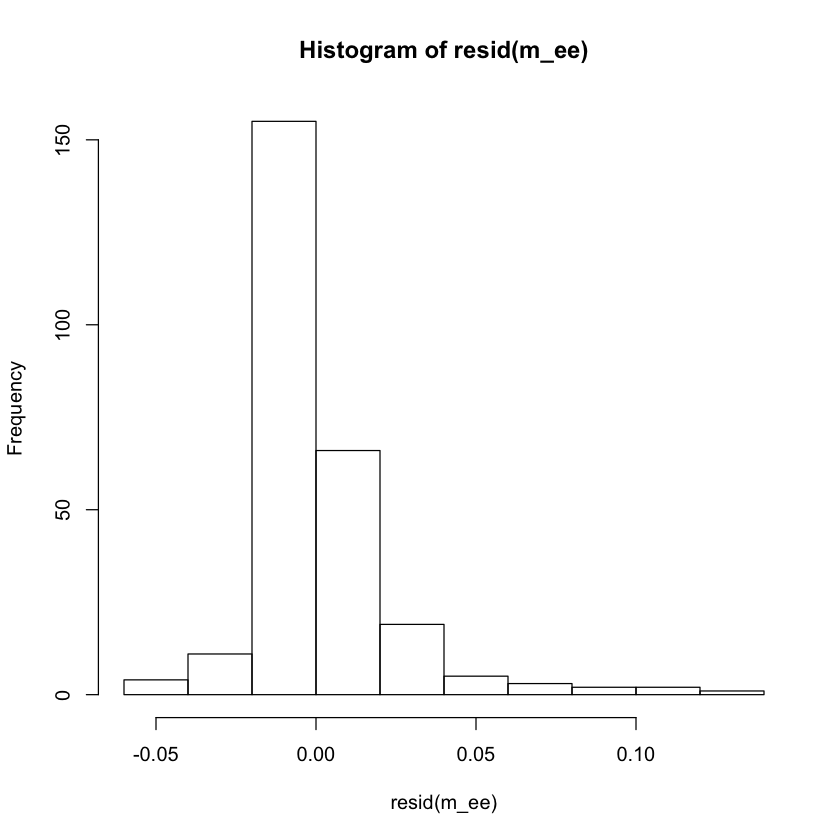

In [74]:
hist(resid(m_ee))

### Individual progress

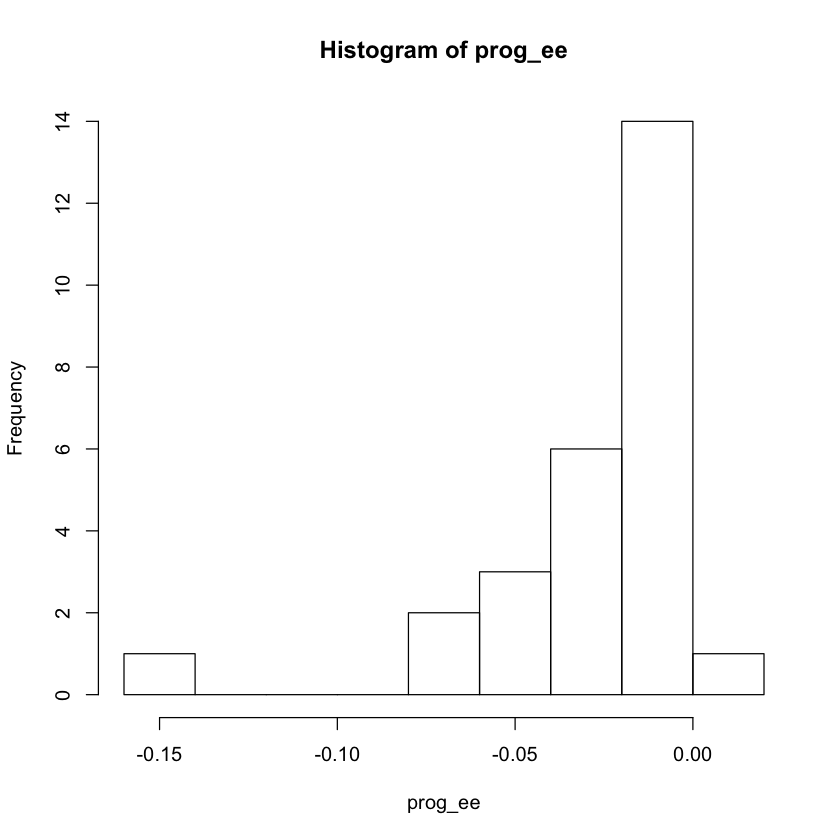

In [75]:
ee_random = ranef(m_ee)
ee_fixed = fixef(m_ee)

start_ee <- ee_random$id$'(Intercept)' + ee_fixed[1]
prog_ee <- (ee_random$id$sess + ee_fixed[2])*10

hist(prog_ee)

In [76]:
results$ee <- prog_ee

# Inspect all results

In [77]:
results

,id,apples,fish,ee,jigsaw
1,1,-0.1618234,-0.07959164,-0.003474102,33.09344
2,2,-0.08021113,-0.02604159,-0.0006661022,32.9535
3,3,0.09496145,-0.0720424,-0.0049096,42.01832
4,4,-0.215258,-0.04380605,-0.01356652,7.533003
5,5,-0.1551803,-0.04437142,-0.0001328709,13.34788
6,6,-0.06780108,-0.1005514,-0.008669108,28.96862
7,7,-0.01667605,-0.04855782,-0.04521051,3.544579
8,8,-0.06408143,-0.1165972,-0.01562981,-6.506389
9,9,0.01098467,-0.0470315,-0.02350784,19.43559
10,10,-0.08099651,-0.0941509,-0.02988404,10.61691


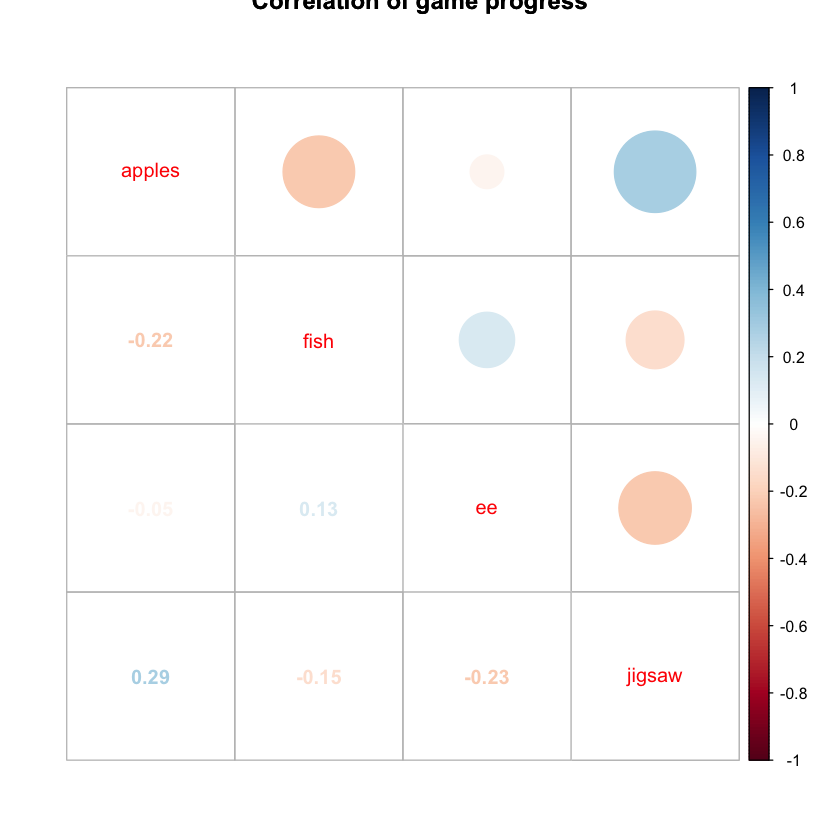

In [78]:
corrplot.mixed(cor(results[,2:5]), upper = 'circle', lower = 'number', main = 'Correlation of game progress')

In [79]:
write.csv(results, '/Users/marcel/projects/treningi_Justyna/artykul/game_progress.csv')